### Primal Slab SVM
Let $K \in R^{m \times m}$ and $K_{ij} = \texttt{kernel}(x_i,x_j)$ and $K_{i}$ the $i^{th}$ column of $K$

Then Primal Minimization Objective:
$$\min_{\beta \in R^m,\rho \in R} \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta, \rho)$$

Let $F$ be the objective function.
$$F(\beta,\rho) = \beta^T K \beta + \frac{1}{\nu m} \sum_i \texttt{loss}(K_i^T \beta, \rho)$$


Gradients:
$$\vec\nabla_\beta F(\beta,\rho) = 2K\beta + \frac {1}{\nu m} \sum_i K_i \circ \frac{d}{d\beta}\texttt{loss}(K_i^T \beta, \rho)$$
$$\nabla_\rho F(\beta,\rho) = \frac {1}{\nu m} \sum_i \frac{d}{d\rho}\texttt{loss}(K_i^T \beta, \rho)$$


Hessians:
$$H_\beta = 2K + \frac {1}{\nu m} \sum_i \left( K_i \circ K_i \right) \circ \frac{d^2}{(d\beta)^2}\texttt{loss}(K_i^T \beta, \rho)$$
$$H_\rho = \frac {1}{\nu m} \sum_i \frac{d^2}{(d\rho)^2}\texttt{loss}(K_i^T \beta, \rho)$$


We consider losses:
$$\texttt{loss}_{hinge}(t,\rho) = \max(~0,~ |~\rho - t~| - \delta ~)$$
$$\texttt{loss}_{square-hinge}(t,\rho) = \max(~0,~ |~\rho - t~| - \delta ~)^2$$


Loss Gradients:
$$\frac{d}{dt}\texttt{loss}_{hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-1, & \mbox{if } ~\rho - t~ \gt \delta  \\
1, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d}{dt}\texttt{loss}_{square-hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
-2\left(\rho-t-\delta\right), & \mbox{if } ~\rho - t~ \gt \delta  \\
2\left(-\rho+t-\delta\right), & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$


$$\frac{d}{d\rho}\texttt{loss}_{hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
1, & \mbox{if } ~\rho - t~ \gt \delta  \\
1, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d}{d\rho}\texttt{loss}_{square-hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
2\left(\rho-t-\delta\right), & \mbox{if } ~\rho - t~ \gt \delta  \\
-2\left(-\rho+t-\delta\right), & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$


Loss Hessians:
$$\frac{d^2}{(dt)^2}\texttt{loss}_{hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
0, & \mbox{if } ~\rho - t~ \gt \delta  \\
0, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d^2}{(dt)^2}\texttt{loss}_{square-hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
2, & \mbox{if } ~\rho - t~ \gt \delta  \\
2, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d^2}{(d\rho)^2}\texttt{loss}_{hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
0, & \mbox{if } ~\rho - t~ \gt \delta  \\
0, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$

$$\frac{d^2}{(d\rho)^2}\texttt{loss}_{square-hinge}(t,\rho) = \begin{cases} 0, & \mbox{if } |~\rho - t~| \lt \delta \\ 
2, & \mbox{if } ~\rho - t~ \gt \delta  \\
2, & \mbox{if } ~-\rho + t~ \gt \delta  \end{cases}$$


Evaluation:
$$ \langle \Phi(x), w\rangle = \sum_k \beta_k k(x_k, x) $$
Surface:
$$ \langle \Phi(x), w\rangle -\rho = \sum_k \beta_k k(x_k, x) -\rho $$

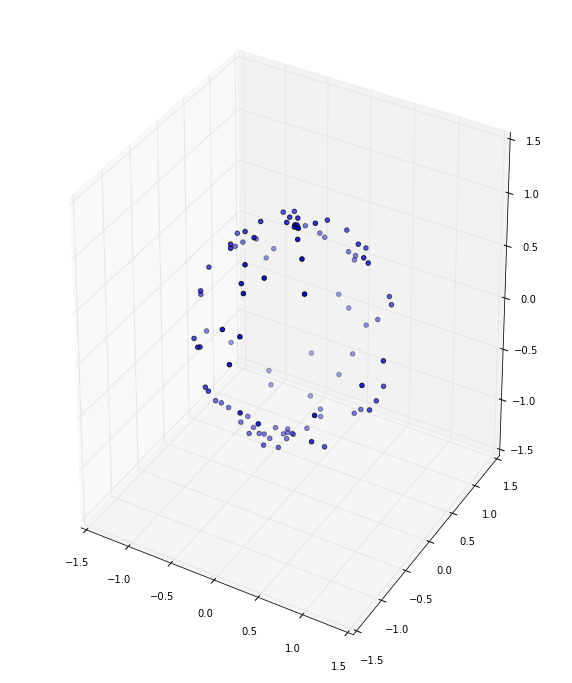

-----------------------------------
loss_type square-hinge
method Newton
Stopping crit: obj small 1.81322131847e-07
grad_des: 1.17700695992 sec
Desc iterations 19
Desc rho 1.00237073539
-----------------------------------

-----------------------------------
loss_type square-hinge
method 
grad_des: 6.94637489319 sec
Desc iterations 100
Desc rho 2.04323106629
-----------------------------------

-----------------------------------
loss_type hinge
method Newton
grad_des: 7.69675207138 sec
Desc iterations 100
Desc rho 0.999999982
-----------------------------------

-----------------------------------
loss_type hinge
method 
grad_des: 7.56976485252 sec
Desc iterations 100
Desc rho 1.000000006
-----------------------------------



/Users/mich/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [4]:
%matplotlib inline

import numpy as np
from numpy import linalg, random, ones, zeros
from numpy.linalg import norm,cholesky,inv
from sklearn.cross_validation import train_test_split
import mosek
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
import time 
from collections import namedtuple

v=.00001
delta = 0.0
sigma = 100
initial_rho = 1
max_iter = 100
initial_step_size = .1
timer_thresh = .1
ep = .000001
x=np.zeros((0))
K=np.zeros((0))
K_inv=np.zeros((0))
points_count = 100
points_std_from_surface = 0

from numpy import eye,dot

def pivot(A,k,n):
    y = np.amax(np.absolute(A[k:n+1, k:n+1]),axis=1)
    i = np.argmax(np.absolute(A[k:n+1, k:n+1]),axis=1)
    piv = np.amax(y)
    jpiv = np.argmax(y)
    ipiv = i[jpiv]
    jpiv = jpiv+k-1;
    ipiv = ipiv + k-1;
    Pk=eye(n)
    Pk[ipiv,ipiv]=0
    Pk[k,k]=0
    Pk[k,ipiv]=1
    Pk[ipiv,k]=1
    Qk=eye(n)
    Qk[jpiv,jpiv]=0
    Qk[k,k]=0
    Qk[k,jpiv]=1
    Qk[jpiv,k]=1
    return Pk,Qk

def incomplete_LU_decomp(A):
    start = time.time()
    
    assert A.shape[0] == A.shape[1]
    n = A.shape[0]
    for k in range(n-1):
        Pk,Qk = pivot(A,k,n)
        A=dot(dot(Pk,A),Qk)
        print A
        for i in range(k+1,n):
            if A[i,k] != 0:
                if A[k,k] == 0:
                    return 'Error: Null Pivot'
                A[i,k] = A[i,k]/A[k,k]
                for j in range(k+1,n):
                    if A[i,j] != 0:
                        A[i,j] = A[i,j] - (A[i,k]/A[k,j])
                        
    end = time.time()
    if end - start > timer_thresh:
        print 'incomplete_LU_decomp:',end - start,'sec'
    return A

def H(beta,rho,loss_vect_list,opt_on):
    start = time.time()
    
    assert loss_type != 'hinge'

    if opt_on=='b':
        ret = 2*K + 2/(v*len(x))*np.sum(K[:,loss_vect_list]*K[:,loss_vect_list], axis=0)
    elif opt_on == 'rho':
        ret = 2/(v*len(x))

    end = time.time()
    if end - start > timer_thresh:
        print 'H:',end - start,'sec'
    return ret

def loss_der_der(t,rho):
    if loss_type == 'hinge':
        return 0
    if loss_type == 'square-hinge':
        if abs(rho - t) < delta:
            return 0
        else:
            return 2
    raise Exception(loss_type,t,rho,delta)

def loss_der(t,rho,opt_on):
    if loss_type == 'hinge':
        if abs(rho - t) <= delta:
            return 0
        if rho - t > delta:
            return -1
        if -rho + t > delta:
            return 1
    if loss_type == 'square-hinge':
        if abs(rho - t) <= delta:
            return 0
        if opt_on=='b':
            if rho - t > delta:
                return -2*(rho - t - delta)
            if -rho + t > delta:
                return 2*(-rho + t - delta)
        if opt_on=='rho':
            if rho - t > delta:
                return 2*(rho - t - delta)
            if -rho + t > delta:
                return -2*(-rho + t - delta)
    raise Exception(loss_type,t,rho,delta)
        
def obj_grad(beta,rho,opt_on):
    start = time.time()
    
    if opt_on == 'b':
        ret = 2*np.dot(K,beta)
        for i in range(len(ret)):
            ret += 1/(v*len(x))*K[:,i]*loss_der(np.dot(K[:,i],beta),rho,opt_on)
    elif opt_on == 'rho':
        ret = 0
        for i in range(len(x)):
            ret += 1/(v*len(x))*loss_der(np.dot(K[:,i],beta),rho,opt_on)
            
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_grad:',end - start,'sec'
    return ret

def kernel(x1,x2):
    return math.exp(-1*math.pow(norm(x1-x2),2
                               )/(2*math.pow(sigma, 2)))

def kernel_vect(x_list,x2):
    return np.exp(-1*np.power(norm(x_list-x2,axis=1),2 )/(2*math.pow(sigma, 2)))

def loss(t,rho):
    if loss_type == 'hinge':
        return max(0, abs(rho - t) - delta )
    if loss_type == 'square-hinge':
        return max(0, abs(rho - t) - delta )**2

def obj_funct(beta,rho):
    start = time.time()
    
    m = len(x)
    loss_sum = 0
    for i in range(len(x)):
        loss_sum += loss(np.dot(K[:,i],beta),rho)
    obj = 1/2*np.dot(beta.T,np.dot(K,beta)) + 1 / (v*m) * loss_sum
    
    end = time.time()
    if end - start > timer_thresh:
        print 'obj_funct:',end - start,'sec'
    return obj

def f(x_test, beta,rho):
    start = time.time()
    
    w = np.dot(beta,kernel_vect(x,x_test)) - rho
            
    end = time.time()
    if end - start > timer_thresh:
        print 'f:',end - start,'sec'
    return w

def step(element,step_size,resid):
    return element - (step_size * resid)

def backtrack_step_size(step_size,obj,resid,beta,rho,opt_on):
    start = time.time()
    if step_size == ep**2:
        step_size = initial_step_size
    elif method == 'Newton':
        pass
    else:
        step_size *= 2.0
    while obj < (obj_funct( step(beta,step_size,resid),rho) if opt_on=='b' \
                         else obj_funct( beta, step(rho,step_size,resid)) ):
        step_size = step_size * 0.6
        if step_size < ep**2:
#             print 'WARNING: step size not found'
            step_size = ep**2
            end = time.time()
            if end - start > timer_thresh:
                print 'backtrack_step_size:',end - start
            return step_size

    assert obj >= (obj_funct( step(beta,step_size,resid),rho) if opt_on=='b' \
                         else obj_funct( beta, step(rho,step_size,resid)) )
    
    end = time.time()
    if end - start > timer_thresh:
        print 'backtrack_step_size:',end - start,'sec'
    return step_size

def numer_grad(beta,rho,ep,direct=0,opt_on=''): # const
    if opt_on == 'rho':
        return (obj_funct(beta,rho+ep) \
               -obj_funct(beta,-rho*ep))/(2*ep)
    return (obj_funct(beta+(ep*direct),rho) \
           -obj_funct(beta-(ep*direct),rho))/(2*ep)

def grad_checker(beta,rho,ep,opt_on): # const
    if opt_on == 'rho':
        return numer_grad(beta,rho,ep,opt_on=opt_on)

    d=len(beta)
    w=np.zeros(d)
    for i in range(d):
        direct=np.zeros(beta.shape)
        direct[i] = 1
        w[i]=(numer_grad(beta,rho,ep,direct=direct,opt_on=opt_on))
    return w

def get_resid(beta,rho,grad,loss_vect_list,opt_on):
    start = time.time()
    
#     if loss_type == 'square-hinge':
#         resid = linalg.solve(
#             2*K + 2/(v*len(x))*np.sum(K[:,loss_vect_list]*K[:,loss_vect_list], 
#                                       axis=0),
#                              grad)
#     else:

    if opt_on=='b':
        resid = linalg.solve(H(beta,rho,loss_vect_list,opt_on),grad)
    else:
        resid = grad/H(beta,rho,loss_vect_list,opt_on)
        
    end = time.time()
    if end - start > timer_thresh:
        print 'get_resid:',end - start,'sec'
    return resid

def grad_des_iterate(beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,
                     obj_grad_check_array,iterations,opt_on='b'):
    start = time.time()
    
    loss_vect_list = None
    for j in range(K.shape[1]):
        if abs(rho - np.dot(K[:,j],beta)) >= delta :
            if loss_vect_list == None:
                loss_vect_list = np.asarray([ j ])
            else:
                loss_vect_list = np.append(loss_vect_list, j)

    obj = obj_funct(beta,rho)
#     print 'obj',obj
    obj_array[iterations]=(obj)

    grad = obj_grad(beta,rho,opt_on)
    obj_grad_array[iterations]=norm(grad)
    obj_grad_check_array[iterations]=norm((grad-grad_checker(beta,rho,ep,opt_on)))

#     if (iterations>0 and abs(obj_array[iterations]-obj_array[iterations-1])<ep):
#         print 'Stopping crit: change in obj',abs(obj_array[iterations]-obj_array[iterations-1])
#         return True,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array
    if obj < ep:
        print 'Stopping crit: obj small',obj
        return True,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array
    if norm(grad) < ep:
        print 'Stopping crit: norm(grad) small',norm(grad)
        return True,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array

    if loss_type == 'square-hinge' and method == 'Newton':
        resid = get_resid(beta,rho,grad,loss_vect_list,opt_on)
        step_size_beta = 1
        step_size_rho = 1
    else:
        resid = (grad)

    if opt_on == 'rho':
        step_size_rho = backtrack_step_size(step_size_rho,obj,resid,beta,rho,opt_on)
        rho = step(rho,step_size_rho,resid) # Update
    else:
        step_size_beta = backtrack_step_size(step_size_beta,obj,resid,beta,rho,opt_on)
        beta = step(beta,step_size_beta,resid) # Update

    end = time.time()
    if end - start > timer_thresh:
        print 'grad_des_iterate:',end - start,'sec'

    return False,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array

def grad_des():
    start = time.time()
    obj_array = -1*np.ones(max_iter)
    obj_grad_array = np.zeros((max_iter))
    obj_grad_check_array = np.zeros(max_iter)

    beta = zeros(len(x))
    step_size_beta = initial_step_size
    step_size_rho = initial_step_size
    rho = initial_rho
    iterations = 0
    for i in range(max_iter):
        converged,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array = \
                        grad_des_iterate(beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,
                                         obj_grad_check_array,iterations,opt_on='b')
        
        if converged:
            break

        converged,beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,obj_grad_check_array = \
                        grad_des_iterate(beta,rho,step_size_beta,step_size_rho,obj_array,obj_grad_array,
                                         obj_grad_check_array,iterations,opt_on='rho')
        
        if converged:
            break
        
        if i == max_iter-1:
            print 'WARNING: Did not converge'
            
        iterations += 1

    end = time.time()
    if end - start > timer_thresh:
        print 'grad_des:',end - start,'sec'
    return Run(obj_array,obj_grad_array,obj_grad_check_array,beta,rho,iterations)

def get_data_points():
    start = time.time()
    points = random.random((points_count,2))*2*np.pi

    x = np.zeros((len(points),3))
    for p in range(len(points)):
        if points_std_from_surface > 0:
            r = random.normal(loc=1,scale=points_std_from_surface)
        else:
            r = 1
        z_cord = r * np.sin(points[p][1])

        r_temp = r * np.cos(points[p][1])
        y_cord = r_temp * np.sin(points[p][0])
        x_cord = r_temp * np.cos(points[p][0])

        x[p] = np.asarray([x_cord, y_cord, z_cord])
            
    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:',end - start,'sec'
    return x

def get_K():
    start = time.time()
    K=np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            K[i,j] = kernel(x[i],x[j])

    end = time.time()
    if end - start > timer_thresh:
        print 'get_K:',end - start,'sec'
    return K

def get_K_inv(K):
    start = time.time()

    K_inv = inv(K)
    
    end = time.time()
    if end - start > timer_thresh:
        print 'get_K_inv:',end - start,'sec'
    return K_inv

import scipy
def get_K_LU():
    K_LU = scipy.linalg.cholesky(K, lower=True)
    K_LU = cholesky(K)
    K_LU2 = incomplete_LU_decomp(K.copy())
        
    assert K_LU.shape == K_LU2.shape
    for k in range(K_LU.shape[0]):
        for i in range(K_LU.shape[1]):
            assert abs(K_LU[k,i] - K_LU2[k,i]) < ep

def pre_comp_K():
    start = time.time()

    K = get_K()
        
    if linalg.cond(K) < 1/sys.float_info.epsilon**4:
        K_inv = get_K_inv(K)
    else:
        print 'Warning: K numerical singularity'
        K_inv = np.identity(K.shape[0])
        
    end = time.time()
    if end - start > timer_thresh:
        print 'pre_comp_K:',end - start,'sec'
    return K, K_inv

x = get_data_points()        
        
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2])
plt.show()

K, K_inv = pre_comp_K()    

Run = namedtuple('Run', ['obj_array','obj_grad_array','obj_grad_check_array','beta','rho',
                         'iterations'])

Desc = {}
counter=0
for loss_type in ['square-hinge', 'hinge']:
    for method in ['Newton', '']:
        
        print '-----------------------------------'
        print 'loss_type',loss_type
        print 'method',method        
        Desc[counter] = grad_des()
        print 'Desc iterations',Desc[counter].iterations
        print 'Desc rho',Desc[counter].rho
        print '-----------------------------------'
        print 

        counter += 1


In [5]:
grid_steps = 25

def pop_data_grid(beta,rho):
    start = time.time()
    data = np.zeros((grid_steps,grid_steps,grid_steps))

    x0_range = np.linspace(-2, 2, grid_steps)
    x1_range = np.linspace(-2, 2, grid_steps)
    x2_range = np.linspace(-2, 2, grid_steps)
    end = time.time()
    if end - start > timer_thresh:
        print 'alloc mem:',end - start

    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                data[i,j,k] = f(np.asarray([x0_range[i],
                                x1_range[j],
                                x2_range[k]]), beta,rho)
                
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid:',end - start,'sec'
    return data

def proc_data(beta,rho,data):
    start = time.time()

    print 'delta',delta
    print 'np.abs(data - delta) < .1 -> ',(np.where(np.abs(data - delta) < .1)[0].shape)
    print 'np.abs(data - delta) < .01 -> ',(np.where(np.abs(data - delta) < .01)[0].shape)
    print 'np.abs(data - delta) < .001 -> ',(np.where(np.abs(data - delta) < .001)[0].shape)
    print 'np.abs(data - delta) < .0001 -> ',(np.where(np.abs(data - delta) < .0001)[0].shape)
    print 'data < delta -> ',(np.where(data < delta )[0].shape)
    print 'data > delta -> ',(np.where(data > delta )[0].shape)
    print 'data < 0 -> ',(np.where( data < 0)[0].shape)
    print 'data == 0 -> ',(np.where( data == 0)[0].shape)
    print 'data > 0 -> ',(np.where( data > 0)[0].shape)
    print 'min -> ',(np.amin( data ))
    print 'max -> ',(np.amax( data ))
#     print 'data:',data
    
    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:',end - start

losses = []
for i in range(len(x)):
    losses.append(f(x[i], Newton_Desc.beta, Newton_Desc.rho))

rho = Desc[0].rho
beta = Desc[0].beta
data = pop_data_grid(beta,rho)


pop_data_grid: 0.583087205887 sec


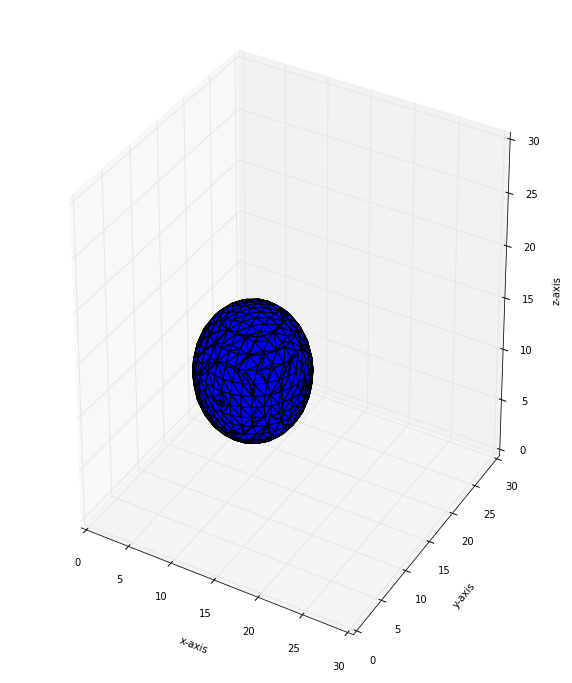

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-0, 30)  
ax.set_ylim(-0, 30)  
ax.set_zlim(-0, 30)  

plt.show()


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

ax.scatter(range(1,Newton_Desc.iterations+1),
           Newton_Desc.obj_array[0:Newton_Desc.iterations],marker='^',
           label='Non-Stochastic Newtons Method')
ax.scatter(range(1,Steepest_Desc.iterations+1),
           Steepest_Desc.obj_array[0:Steepest_Desc.iterations],marker='*',
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Objective Function over iterations')
plt.ylabel('F (w)')
plt.xlabel('Iteration')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

ax.scatter(range(1,(Newton_Desc.iterations)+1),
           Newton_Desc.obj_grad_array[0:Newton_Desc.iterations],
           marker='^',
           label='Non-Stochastic Newtons Method')

ax.scatter(range(1,(Steepest_Desc.iterations)+1),
           Steepest_Desc.obj_grad_array[0:Steepest_Desc.iterations],
           marker='*', 
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm over iterations')
plt.ylabel('norm(d/dw F (w))')
plt.xlabel('Iteration')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

from numpy.linalg import norm

ax = plt.subplot(1,1,1)

ax.scatter(range(1,(Steepest_Desc.iterations)+1),
           Steepest_Desc.obj_grad_check_array[0:Steepest_Desc.iterations],
           marker='*',
           label='Non-Stochastic Steepest Descent')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Gradient Norm and Approx. Gradient Norm Difference \n over iterations')
plt.ylabel('Difference')
plt.xlabel('Iteration')